In [1]:
#IPython extension to reload modules before executing user code. If we make any change in function and imoprting it we don't need to restart if we use auto reload 
%load_ext autoreload

# to print in between values as well without print
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [99]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pickle


# sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.cluster import DBSCAN
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder


# scipy
from scipy.stats import boxcox
from scipy.stats import skew

# Supporting Functions

In [3]:
# to save pickle file
def save_pkl_model(path,model):
    pickle.dump(model, open(path,'wb'))


In [4]:
# to load pickle file
def load_pkl_model(path):
    sc = pickle.load(open(path,'rb'))
    return sc

In [5]:
# to save csv file 
def save_csv_file(path, data):
    # The frac keyword argument specifies the fraction of rows to return in the random sample, so frac=1 means to return all rows (in random order).
    np.random.seed(0)
    train_save = data.sample(frac=1).reset_index(drop=True)
    train_save.to_csv(path,index=False)

# DATA Pre Processing


1. Check for Data/Data Types and Bad Data
2. Check Columns Names
3. Check for data Imbalance  
4. Divide in train and test based on data imbalance 
5. Check for Missing Values
6. Imputation of missing values
7. Checks and remove outliers
8. Perform new feature imputation if needed
9. Feature Selection
10. Check for distribution type and Perform necessary transformations if needed
11. Scaling the data
12. Binning Continuous data if needed

**Iterative Process**

1. Training and Feature selection

In [6]:
# load database
data = pd.read_csv('Data/ORG_xAPI-Edu-Data.csv')
data.head()

,gender,NationalITy,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,raisedhands,VisITedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class
0,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,15,16,2,20,Yes,Good,Under-7,M
1,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,20,20,3,25,Yes,Good,Under-7,M
2,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,10,7,0,30,No,Bad,Above-7,L
3,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,30,25,5,35,No,Bad,Above-7,L
4,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,40,50,12,50,No,Bad,Above-7,M


## 1. checking data and types
We generally don't tend to care about data types until we get an error or some unexpected results. It should be one of the first things we should check once we load a new data into pandas for further analysis. We need to be sure if pandas has loaded all the types correctly.

Resource - https://pbpython.com/pandas_dtypes.html

In [7]:
data.dtypes

gender                      object
NationalITy                 object
PlaceofBirth                object
StageID                     object
GradeID                     object
SectionID                   object
Topic                       object
Semester                    object
Relation                    object
raisedhands                  int64
VisITedResources             int64
AnnouncementsView            int64
Discussion                   int64
ParentAnsweringSurvey       object
ParentschoolSatisfaction    object
StudentAbsenceDays          object
Class                       object
dtype: object

In [8]:
# T will represent the transpose of the resulting dataframe, better for visualization
data.describe(include='O').T

,count,unique,top,freq
gender,480,2,M,305
NationalITy,480,14,KW,179
PlaceofBirth,480,14,KuwaIT,180
StageID,480,3,MiddleSchool,248
GradeID,480,10,G-02,147
SectionID,480,3,A,283
Topic,480,12,IT,95
Semester,480,2,F,245
Relation,480,2,Father,283
ParentAnsweringSurvey,480,2,Yes,270


In [9]:
# check if all the categories make sense
for col in data.select_dtypes(include='O').columns:
    print(data[col].unique())

['M' 'F']
['KW' 'lebanon' 'Egypt' 'SaudiArabia' 'USA' 'Jordan' 'venzuela' 'Iran'
 'Tunis' 'Morocco' 'Syria' 'Palestine' 'Iraq' 'Lybia']
['KuwaIT' 'lebanon' 'Egypt' 'SaudiArabia' 'USA' 'Jordan' 'venzuela' 'Iran'
 'Tunis' 'Morocco' 'Syria' 'Iraq' 'Palestine' 'Lybia']
['lowerlevel' 'MiddleSchool' 'HighSchool']
['G-04' 'G-07' 'G-08' 'G-06' 'G-05' 'G-09' 'G-12' 'G-11' 'G-10' 'G-02']
['A' 'B' 'C']
['IT' 'Math' 'Arabic' 'Science' 'English' 'Quran' 'Spanish' 'French'
 'History' 'Biology' 'Chemistry' 'Geology']
['F' 'S']
['Father' 'Mum']
['Yes' 'No']
['Good' 'Bad']
['Under-7' 'Above-7']
['M' 'L' 'H']


In [10]:
data.describe(include='number').T

,count,mean,std,min,25%,50%,75%,max
raisedhands,480.0,46.775000,30.779223,0.0,15.75,50.0,75.0,100.0
VisITedResources,480.0,54.797917,33.080007,0.0,20.00,65.0,84.0,99.0
AnnouncementsView,480.0,37.918750,26.611244,0.0,14.00,33.0,58.0,98.0
Discussion,480.0,43.283333,27.637735,1.0,20.00,39.0,70.0,99.0


Comments - Using our domain knowledge, the data is loaded correctly with corresponding data types, categorical variables are correct as well and overall there is no unexpected values

## 2. Check column names

It is always better to deal with column names without spaces make further process easy

In [11]:
data.columns

Index(['gender', 'NationalITy', 'PlaceofBirth', 'StageID', 'GradeID',
       'SectionID', 'Topic', 'Semester', 'Relation', 'raisedhands',
       'VisITedResources', 'AnnouncementsView', 'Discussion',
       'ParentAnsweringSurvey', 'ParentschoolSatisfaction',
       'StudentAbsenceDays', 'Class'],
      dtype='object')

In [12]:
# this is inplace, the column names will get changed
data.columns =[col.replace(' ','_') for col in data.columns]
data.head()

,gender,NationalITy,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,raisedhands,VisITedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class
0,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,15,16,2,20,Yes,Good,Under-7,M
1,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,20,20,3,25,Yes,Good,Under-7,M
2,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,10,7,0,30,No,Bad,Above-7,L
3,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,30,25,5,35,No,Bad,Above-7,L
4,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,40,50,12,50,No,Bad,Above-7,M


Comments - All column names are corrected

## 3. Divide dataset in train and test

We will be only dealing with the training dataset, the test dataset will be unknown till the end of the model, It reflects the same senerio which we get in the real life

The problem - 
1. what if few categories are missed in test dataset, we will be having no one hot encoding for new category corresponding to that ?

Possible Solutions - 
1. when making one hot encoding for categorical variable use both train,test (all information available)
2. When new category arrives all one hot endoded values can be zero
3. retraining the model with the new sample

M    211
H    142
L    127
Name: Class, dtype: int64

<AxesSubplot:>

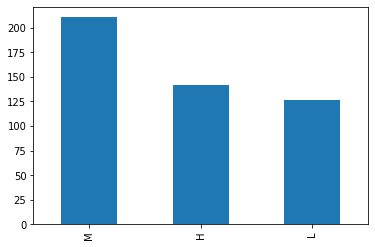

In [13]:
data.Class.value_counts()
data.Class.value_counts().plot(kind = 'bar')

**Data is balanced but it is always good to have stratified split for equal proprtion in train and test**

In [14]:
# random state help to reproduce the same results and stratified split takes care of dividing the data into the same proportion of each class in train and test
# reset the index for train and test
train, test = train_test_split(data, test_size=0.2, shuffle= True, random_state=0, stratify=data['Class'])
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [15]:
# let's check the train data and save test for future
train.describe(include='all').T
test.to_csv('Data/test.csv',index=False)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
gender,384,2,M,244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NationalITy,384,14,KW,145,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PlaceofBirth,384,14,KuwaIT,145,NaN,NaN,NaN,NaN,NaN,NaN,NaN
StageID,384,3,MiddleSchool,203,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GradeID,384,10,G-02,113,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SectionID,384,3,A,229,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Topic,384,12,IT,78,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Semester,384,2,F,201,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relation,384,2,Father,226,NaN,NaN,NaN,NaN,NaN,NaN,NaN
raisedhands,384.0,NaN,NaN,NaN,46.96875,31.101855,0.0,15.0,50.0,76.25,100.0


Comments - Data was balanced, although used stratified split and saved the test data  

## 4. check for missing values

Check for missing values as it can give errors during EDA and can produce incorrect results during model training

In [16]:
# a basic first step is to check if any data is missing in predicted value, because if some lable in not there in y_train, there is no point to include that row  
train['Class'].isnull().any()

False

In [17]:
# check the missing values columns (if true means it is has missing value)
train.isnull().any()

gender                      False
NationalITy                 False
PlaceofBirth                False
StageID                     False
GradeID                     False
SectionID                   False
Topic                       False
Semester                    False
Relation                    False
raisedhands                 False
VisITedResources            False
AnnouncementsView           False
Discussion                  False
ParentAnsweringSurvey       False
ParentschoolSatisfaction    False
StudentAbsenceDays          False
Class                       False
dtype: bool

In [18]:
# get the missing columns
null_series = train.isnull().any()
null_cols = list(null_series[null_series==True].index)
null_cols

[]

In [19]:
# count missing values
train[null_cols].isnull().sum()

Series([], dtype: float64)

<!-- Comments - Two columns contains missing values, one is Topic which is categorical and another is raisedhands which is numerical with 2 and 3 missing values respectively -->
Comments - Data contains no missing values

## 5. Compute Missing values

**A generalized model for missing values so that if values are missing in test data the model will not break** \
**Although tree based algorithms manages the missing values by default so we do not need to run the computer for tree based algorithams**

There are multiple ways to compute missing values. Although most of them are distance based and only work on numeric features. Missing values are computed on training data only otherwise it can cause data leackage as well. Data Leakage refers to a mistake that is made by the creator of a machine learning model in which they accidentally share the information between the test and training data sets

   
1. We can manually check what value is missing and can correct that, we can check if, Is there a pattern to the missing values,  think about possible reasons why it happened in the first place

2. Also it is know practive to drop the column if it has more than 60% of the missing values 
   
3. Deleting Rows with missing values - Deleting rows (if we have enough data) or column (if column is not important intutive idea from domain knowledge)

4. Impute missing values for continuous variable - mean/median  - without causing data leakage

5. Impute missing values for categorical variable - mode

6. Other Imputation Methods - interpolation (provide missing term using nearby trends, newton forward/backward formula, for multivariate - nearest neighbour interpolation, gaussian, polynomial (good for time series interpolation))

7. Using Algorithms that support missing values (k-NN - based on k, get the closest rows using euclidean distance and take the average of there missing value column values)

In [20]:
print("missing columns are ",null_cols)

missing columns are  []


**knn model**

**Note**
1. We should also use scalling befor applying the algo if columns have very different scales, as it is a distnace based algoritham
2. Although our all numeric feature are of same scale so we do not need such scalling

In [21]:
# function to compute missing values using KNN (numeric feature)
def knn_imp(train_numeric):
    imputer = KNNImputer(n_neighbors=5)
    imputer.fit(train_numeric)    
    imp_transformed = imputer.transform(train_numeric)
    imp_transformed_df = pd.DataFrame(imp_transformed,columns=train_numeric.columns)
    imp_transformed_df = imp_transformed_df.set_index(train.index)
    return imp_transformed_df,imputer

In [22]:
# function to compute missing values using mode (categoric feature)
def simple_imp(train_numeric):
    imputer = SimpleImputer(strategy='most_frequent')
    imputer.fit(train_numeric)    
    imp_transformed = imputer.transform(train_numeric)
    imp_transformed_df = pd.DataFrame(imp_transformed,columns=train_numeric.columns)
    imp_transformed_df = imp_transformed_df.set_index(train.index)
    return imp_transformed_df,imputer

In [23]:
# fill categorical missing values and save model 
train_categoric_transformed,imputer_cat = simple_imp(train.select_dtypes(include='O').iloc[:,:-1])
save_pkl_model('Data/processing_models/imputer_cat.pkl',imputer_cat)

In [24]:
# fill numeric missing values and save model 
train_numeric_transformed,imputer_num = knn_imp(train.select_dtypes(include='number'))
save_pkl_model('Data/processing_models/imputer_num.pkl',imputer_num)

In [25]:
# replace values in columns
train[train.select_dtypes(include='O').columns[:-1]] = train_categoric_transformed
train[train.select_dtypes(include='number').columns] = train_numeric_transformed

In [26]:
# check if any null value
train.isnull().any()

gender                      False
NationalITy                 False
PlaceofBirth                False
StageID                     False
GradeID                     False
SectionID                   False
Topic                       False
Semester                    False
Relation                    False
raisedhands                 False
VisITedResources            False
AnnouncementsView           False
Discussion                  False
ParentAnsweringSurvey       False
ParentschoolSatisfaction    False
StudentAbsenceDays          False
Class                       False
dtype: bool

Comments - missing values are filled, train data does not contain any misssing value now

## 6. Check for outliers
For outliers we only deal with training data. There are various methods to try.
1. Box plots
2. Z score test
3. model based (One class SVM, density based, etc)


**Box Plots**

In [52]:
# get all numeric columns
train_numeric = train.select_dtypes(include="number")
train_numeric.shape
train_numeric.head()

(384, 4)

,raisedhands,VisITedResources,AnnouncementsView,Discussion
0,70.0,69.0,46.0,45.0
1,12.0,30.0,0.0,17.0
2,49.0,70.0,19.0,75.0
3,72.0,87.0,72.0,89.0
4,70.0,92.0,50.0,7.0


<AxesSubplot:>

array([<AxesSubplot:title={'center':'raisedhands'}>], dtype=object)

<AxesSubplot:>

array([<AxesSubplot:title={'center':'VisITedResources'}>], dtype=object)

<AxesSubplot:>

array([<AxesSubplot:title={'center':'AnnouncementsView'}>], dtype=object)

<AxesSubplot:>

array([<AxesSubplot:title={'center':'Discussion'}>], dtype=object)

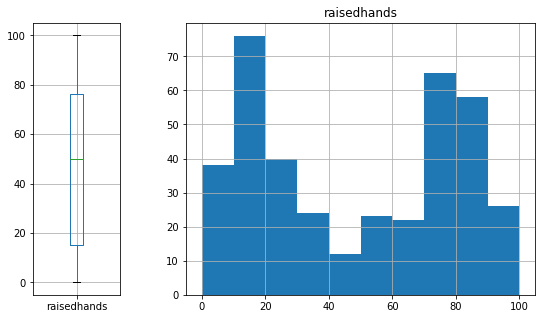

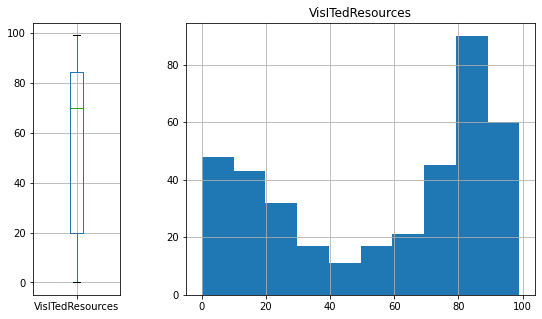

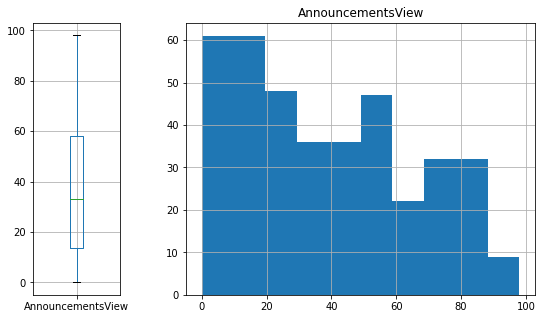

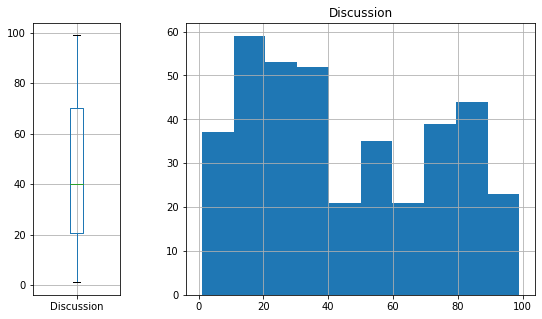

In [53]:
# plotting box plots for all the numeric data to check outliers
total_num_cols = len(train_numeric.columns)
for col in train_numeric.columns:
    fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
    train.boxplot(column=col,ax=axes[0]);
    train.hist(column=col, ax=axes[1]);

#### Why 1.5 IQR only
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/1a/Boxplot_vs_PDF.svg/1024px-Boxplot_vs_PDF.svg.png" alt="nice_image_from_wikipedia" width="450"/>

Resource -  why 1.5 IQR only. 
https://math.stackexchange.com/questions/966331/why-john-tukey-set-1-5-iqr-to-detect-outliers-instead-of-1-or-2

<AxesSubplot:>

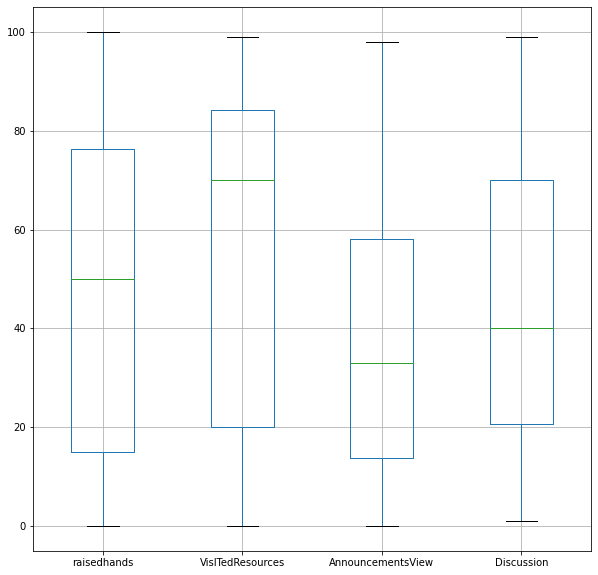

In [54]:
# all box plots 
train[train_numeric.columns].boxplot(figsize=(10,10))

<!-- **Identified outlier from the box plot and removing it** -->

In [55]:
# Q1 = train['Discussion'].quantile(0.25)
# Q3 = train['Discussion'].quantile(0.75)
# IQR = Q3 - Q1
# Q1, Q3, IQR

In [56]:
# # sum of outliers above and below
# small_outliers = train['Discussion'] < (Q1 - 1.5 * IQR)
# big_outliers = train['Discussion'] > (Q3 + 1.5 * IQR)
# sum(small_outliers), sum(big_outliers)

In [57]:
# # removing outlier from train, and plotting again to check
# train = train[~(small_outliers | big_outliers)]

# fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
# train.boxplot(column='Discussion',ax=axes[0]);
# train.hist(column='Discussion', ax=axes[1]);

**DBSCAN for Checking noise**

In [58]:
outlier_detection = DBSCAN(min_samples = 3, eps = 0.4)

In [59]:
normalized_df=(train_numeric-train_numeric.min())/(train_numeric.max()-train_numeric.min())
clusters = outlier_detection.fit_predict(normalized_df)

In [60]:
list(clusters).count(-1)

0

Comments - The box plot denotes there is no outlier in our case, removed outlier and data is cleaned 

## 7. Feature Engineering

In [94]:
train.head()

,gender,NationalITy,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,raisedhands,VisITedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class
0,F,Jordan,Jordan,MiddleSchool,G-08,A,Geology,F,Mum,70.0,69.0,46.0,45.0,Yes,Good,Above-7,M
1,M,KW,KuwaIT,lowerlevel,G-02,B,IT,F,Father,12.0,30.0,0.0,17.0,No,Good,Above-7,L
2,F,KW,KuwaIT,HighSchool,G-11,A,Science,F,Mum,49.0,70.0,19.0,75.0,Yes,Good,Under-7,H
3,M,Iraq,Iraq,MiddleSchool,G-08,A,History,F,Father,72.0,87.0,72.0,89.0,Yes,Good,Above-7,M
4,F,KW,KuwaIT,lowerlevel,G-02,B,IT,F,Mum,70.0,92.0,50.0,7.0,Yes,Good,Under-7,H


# 8. Feature Selection

In [96]:
num_columns = train.select_dtypes(include="number")
num_columns.head()

,raisedhands,VisITedResources,AnnouncementsView,Discussion
0,70.0,69.0,46.0,45.0
1,12.0,30.0,0.0,17.0
2,49.0,70.0,19.0,75.0
3,72.0,87.0,72.0,89.0
4,70.0,92.0,50.0,7.0


In [119]:
cat_columns = train.select_dtypes(include="O")
# cat_columns = cat_columns[[col for col in cat_columns if col not in ['Class']]]
cat_columns.head()

,gender,NationalITy,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class
0,F,Jordan,Jordan,MiddleSchool,G-08,A,Geology,F,Mum,Yes,Good,Above-7,M
1,M,KW,KuwaIT,lowerlevel,G-02,B,IT,F,Father,No,Good,Above-7,L
2,F,KW,KuwaIT,HighSchool,G-11,A,Science,F,Mum,Yes,Good,Under-7,H
3,M,Iraq,Iraq,MiddleSchool,G-08,A,History,F,Father,Yes,Good,Above-7,M
4,F,KW,KuwaIT,lowerlevel,G-02,B,IT,F,Mum,Yes,Good,Under-7,H


In [120]:
# ANNOVA TEST for numeric input and categorical output
fs = SelectKBest(score_func=f_classif, k=2)
# apply feature selection
X_selected = fs.fit_transform(num_columns, cat_columns.iloc[:,-1])
fs.pvalues_

array([2.68061728e-45, 1.39053220e-57, 2.70745663e-28, 7.93252220e-09])

In [121]:
num_df = []
for i,j in zip(list(num_columns.columns),list(fs.pvalues_)):
    num_df.append([i,j])
df = pd.DataFrame(num_df,columns=['feature','p_value'])
df

,feature,p_value
0,raisedhands,2.680617e-45
1,VisITedResources,1.390532e-57
2,AnnouncementsView,2.707457e-28
3,Discussion,7.932522e-09


**Comment**\
On significance level of 5% all numeric columns are significant with respect to the output variable

In [122]:
# chi TEST for categorical input and categorical output
fs = SelectKBest(score_func=chi2, k=2)
# apply feature selection
label_encoded_cols = cat_columns.iloc[:,:-1].apply(LabelEncoder().fit_transform)
X_selected = fs.fit_transform(label_encoded_cols, cat_columns.iloc[:,-1])
fs.pvalues_

array([3.66674099e-02, 3.26824613e-02, 1.44016423e-03, 5.84265429e-01,
       4.85896903e-02, 6.56364167e-01, 2.80098417e-03, 9.48147261e-02,
       1.01204580e-08, 6.79843819e-08, 6.71204829e-05, 1.15039638e-15])

In [123]:
num_df = []
for i,j in zip(list(cat_columns.columns)[:-1],list(fs.pvalues_)):
    num_df.append([i,j])
df = pd.DataFrame(num_df,columns=['feature','p_value'])
df.round(6)

,feature,p_value
0,gender,0.036667
1,NationalITy,0.032682
2,PlaceofBirth,0.001440
3,StageID,0.584265
4,GradeID,0.048590
5,SectionID,0.656364
6,Topic,0.002801
7,Semester,0.094815
8,Relation,0.000000
9,ParentAnsweringSurvey,0.000000


**Comment**
1. On significance level of 10% we can remove the column StageID and SectionID
2. On significance level of 5% we can also remove the column Semester, but since it is at the line we can keep it


In [131]:
train_cat_dup1 = cat_columns[[col for col in cat_columns.columns if col not in ['SectionID','StageID']]]
train_cat_dup1

,gender,NationalITy,PlaceofBirth,GradeID,Topic,Semester,Relation,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class
0,F,Jordan,Jordan,G-08,Geology,F,Mum,Yes,Good,Above-7,M
1,M,KW,KuwaIT,G-02,IT,F,Father,No,Good,Above-7,L
2,F,KW,KuwaIT,G-11,Science,F,Mum,Yes,Good,Under-7,H
3,M,Iraq,Iraq,G-08,History,F,Father,Yes,Good,Above-7,M
4,F,KW,KuwaIT,G-02,IT,F,Mum,Yes,Good,Under-7,H
...,...,...,...,...,...,...,...,...,...,...,...
379,M,Palestine,Jordan,G-07,Biology,F,Father,Yes,Good,Under-7,H
380,F,Jordan,Jordan,G-04,Science,F,Father,Yes,Bad,Under-7,M
381,M,KW,KuwaIT,G-02,IT,F,Father,Yes,Bad,Under-7,H
382,M,Jordan,Jordan,G-02,Arabic,F,Father,No,Bad,Above-7,L


In [149]:
train_fselect_1 = pd.concat([num_columns,train_cat_dup1],axis=1)
train_fselect_1.to_csv('Data/transformed/train_fselect_org.csv',index=False)

## 9. Perform necessary transformation 
1. If the data is not normally distributed and highly skewed it is alwas better to transform the data in normal distribution as the most/all of the asumptions for deriving the methods are that they are normally distributed,
2. Although for classifications naive bayes and logistic regresion has the normal distribution assumption not for all


**Why Normally distributed**

1. In Machine Learning, data satisfying Normal Distribution is beneficial for model building. It makes math easier. Models like LDA, Gaussian Naive Bayes, Logistic Regression, Linear Regression, etc., are explicitly calculated from the assumption that the distribution is a bivariate or multivariate normal. Also, Sigmoid functions work most naturally with normally distributed data.
2. Normality is an assumption for the ML models. It is not mandatory that data should always follow normality. ML models work very well in the case of non-normally distributed data also. Models like decision tree, XgBoost, don’t assume any normality and work on raw data as well. Also, linear regression is statistically effective if only the model errors are Gaussian, not exactly the entire dataset.


In [133]:
# datafreame subset, single or multi columns
def scalling(train, type='ss'):
    if type=='ss':
        std_scaler = preprocessing.StandardScaler()
        std_scaler.fit(train)
        train_transform = std_scaler.transform(train)
        df_train_transform = pd.DataFrame(train_transform,columns = train.columns)
        df_train_transform = df_train_transform.set_index(train.index)
        return std_scaler,df_train_transform
    if type=='mms':
        mms_scaler = preprocessing.MinMaxScaler()
        mms_scaler.fit(train)
        train_transform = mms_scaler.transform(train)
        df_train_transform = pd.DataFrame(train_transform,columns = train.columns)
        df_train_transform = df_train_transform.set_index(train.index)
        return mms_scaler,df_train_transform
    if type=='bx':
        pt = preprocessing.PowerTransformer(method='box-cox')
        train_nonzero = train.replace(0,0.000001)
        pt.fit(train_nonzero)
        train_transform = pt.transform(train_nonzero)
        df_train_transform = pd.DataFrame(train_transform,columns = train.columns)
        df_train_transform = df_train_transform.set_index(train.index)
        return pt, df_train_transform

array([[<AxesSubplot:title={'center':'raisedhands'}>,
        <AxesSubplot:title={'center':'VisITedResources'}>],
       [<AxesSubplot:title={'center':'AnnouncementsView'}>,
        <AxesSubplot:title={'center':'Discussion'}>]], dtype=object)

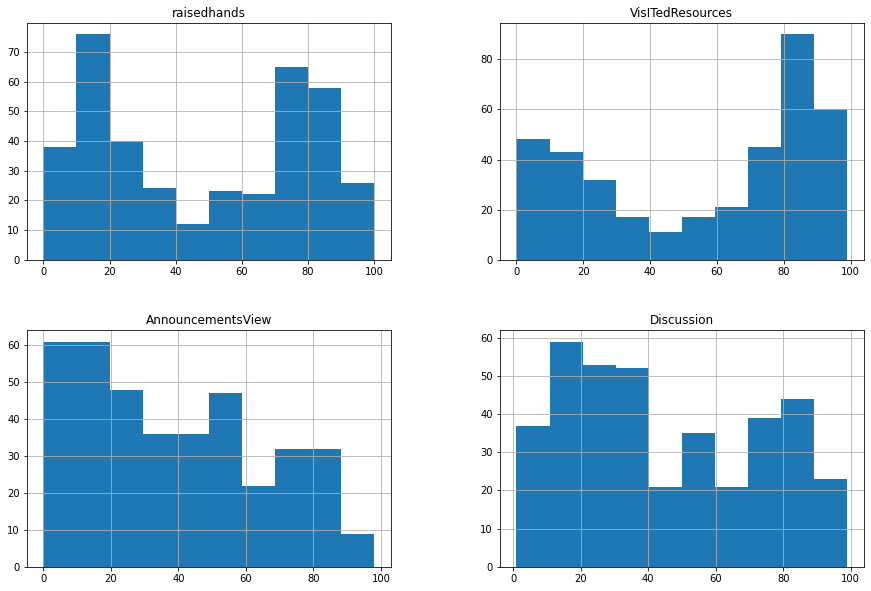

In [134]:
# check data distribution
train[train_numeric.columns].hist(figsize=(15,10))

**data is not highly skewed but not normally distributed either**

In [135]:
# sn.displot(train_numeric.AnnouncementsView,kde=True)

In [136]:
def plot_dist(train_numeric):
    # avg_skewness = (np.abs(np.round(skew(train_numeric),4)).sum())/4
    skewness = np.abs(np.round(skew(train_numeric),4))
    avg_skewness = (np.abs(np.round(skew(train_numeric),4)).sum())/4
    print("The skewness of the data is -",skewness)
    print("The average skewness is - ",avg_skewness)
    train_numeric.plot.kde(subplots=True,layout=(4,3),sharex=False,figsize=(12,12));

In [137]:
# if skewed apply transformations, 
# There are different functions to fit data to normal distribution, we can try and check the which fits the best
def apply_dist_func(train_numeric):
    # original distribution
    print("original distribution")
    plot_dist(train_numeric)

    # log transformation
    print("log transformation")
    log_transform = np.log1p(train_numeric)
    plot_dist(log_transform)

    # square root transformation
    print("Square root transformation")
    sqt_transform = train_numeric**(1/2)
    plot_dist(sqt_transform)

    # resiprocal transformation
    print("resiprocal transformation")
    res_transform = 1/(train_numeric.replace(0,0.00001))
    plot_dist(res_transform)

    # box cox transformation
    print("box-cox transformation")
    scaler, bx_transform  = scalling(train.select_dtypes(include="number"),'bx')
    plot_dist(bx_transform)

original distribution
The skewness of the data is - [0.0245 0.3571 0.3813 0.2837]
The average skewness is -  0.26165
log transformation
The skewness of the data is - [1.1955 1.3632 1.1211 0.9259]
The average skewness is -  1.1514250000000001
Square root transformation
The skewness of the data is - [0.4132 0.7206 0.2714 0.1981]
The average skewness is -  0.40082499999999993
resiprocal transformation
The skewness of the data is - [7.2025 7.8113 6.7098 7.1198]
The average skewness is -  7.210850000000001
box-cox transformation
The skewness of the data is - [0.513  0.6706 0.4651 0.1577]
The average skewness is -  0.4516


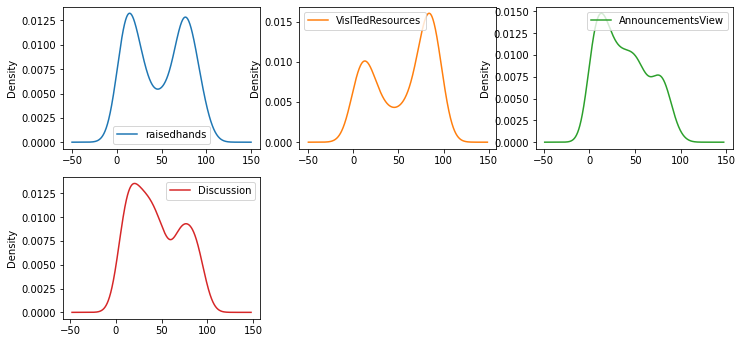

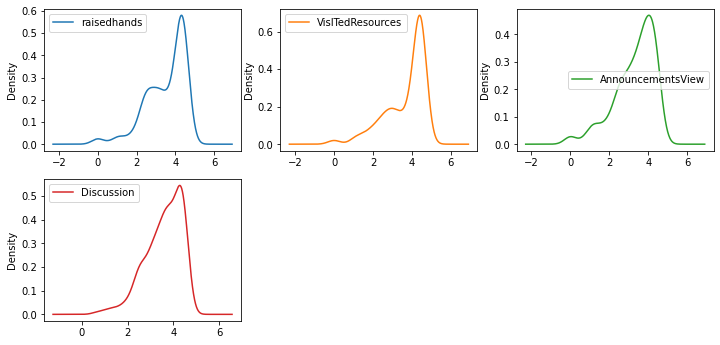

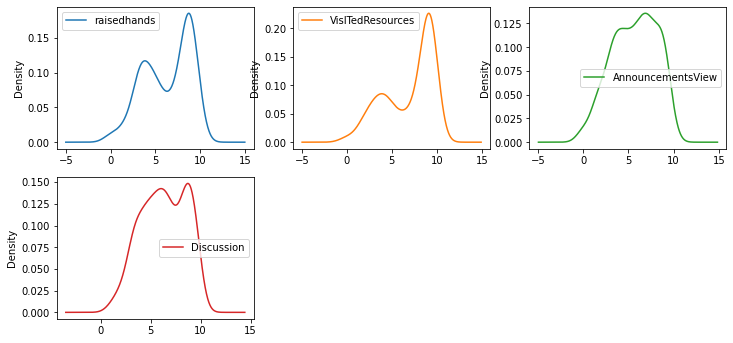

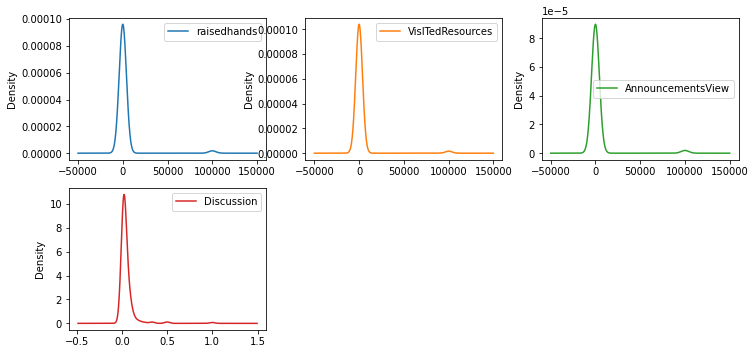

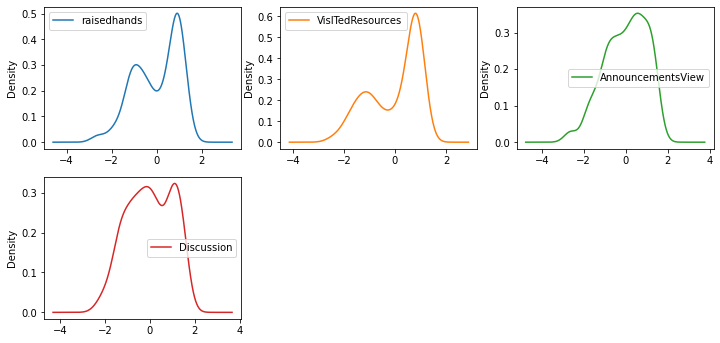

In [138]:
apply_dist_func(train_numeric)

In [139]:
# we can save the data here to test on different scenerios 
train.to_csv('Data/transformed/processed_miss_outlier.csv',index=False)

Comment - 
1. The original skewness was the least one, no transformation is fitting appropriately, the original data itself is closer to normal distribution so haven't applied any
2. We may need to apply different transformation functions for different features, need to confirm it
3. Is skeness is the only measure to check fitting  

## 10. Bining

1. qcut will calculate the size of each bin in order to make sure the distribution of data in the bins is equal, q cut works using quartile, the number of values in each bin will be equal
2. cut will divide the data in different bins based on the values, no gurantees to be in same bin



**WHY to convert numeric into categories and should we convert all to categorical data ?**

in many cases, premature discretization of continuous variables is undesirable. Doing so throws away potentially meaningful data, and the result can be highly dependent on exactly how you bucket the continuous variables, which is usually done rather arbitrarily. Bucketing people by age decade, for example, implies that there is more similarity between a 50-year-old and a 59-year-old than there is between a 59-year-old and a 60-year-old. There can be some advantages in statistical power to doing this, but if your binning doesn't reflect natural cutpoints in the data, you may just be throwing away valuable information.

Sources - https://datascience.stackexchange.com/questions/54244/purpose-of-converting-continuous-data-to-categorical-data

In [69]:
train[train_numeric.columns].describe().T

,count,mean,std,min,25%,50%,75%,max
raisedhands,384.0,46.968750,31.101855,0.0,15.00,50.0,76.25,100.0
VisITedResources,384.0,55.304688,33.157247,0.0,20.00,70.0,84.25,99.0
AnnouncementsView,384.0,37.934896,26.777264,0.0,13.75,33.0,58.00,98.0
Discussion,384.0,44.640625,27.422162,1.0,20.75,40.0,70.00,99.0


In [70]:
# streghty has three options to make bins, we chose k means to gruop similar clusters together
# uniform’: All bins in each feature have identical widths.
# ‘quantile’: All bins in each feature have the same number of points.
# ‘kmeans’: Values in each bin have the same nearest center of a 1D k-means cluster.
def make_bins(train,stg='kmeans'):
    est = preprocessing.KBinsDiscretizer(n_bins=10, encode='ordinal', 
                       strategy=stg)
    est.fit(train)
    est_trasnformed = est.fit_transform(train)

    est_trasnformed_df = pd.DataFrame(est_trasnformed, columns = [col+'_cut' for col in train.columns])
    est_trasnformed_df = est_trasnformed_df.astype('str')
    est_trasnformed_df = est_trasnformed_df.set_index(train.index)
    return est_trasnformed_df, est

In [71]:
train_bin_transformed,bin_enc = make_bins(train_numeric,stg='uniform')
save_pkl_model('Data/processing_models/bin_converter.pkl',bin_enc)
train_bin_transformed

,raisedhands_cut,VisITedResources_cut,AnnouncementsView_cut,Discussion_cut
0,7.0,6.0,4.0,4.0
1,1.0,3.0,0.0,1.0
2,4.0,7.0,1.0,7.0
3,7.0,8.0,7.0,8.0
4,7.0,9.0,5.0,0.0
...,...,...,...,...
379,8.0,9.0,7.0,8.0
380,1.0,5.0,2.0,4.0
381,7.0,9.0,4.0,3.0
382,1.0,1.0,4.0,5.0


In [72]:
train_num_bin = train_bin_transformed

Comments - We used k means bining which seams a better chocie to bin

## One hot and Lable encoding

1. Here we can use Pd.dummies() but it can not handle unknown categories. we may modify it
2. but the better option is sklearn One hot encoder, where we can ignore new category and set that encoded as null

handle_unknown{‘error’, ‘ignore’}, default=’error’
Whether to raise an error or ignore if an unknown categorical feature is present during transform (default is to raise). When this parameter is set to ‘ignore’ and an unknown category is encountered during transform, the resulting one-hot encoded columns for this feature will be all zeros. In the inverse transform, an unknown category will be denoted as None.


In [73]:
# pd.get_dummies(train['NationalITy'], prefix='NationalITy').head()

In [140]:
#ignore tells the encoder to ignore new categories by encoding them with 0's
# dropping first to avoide collinerity
def ohe_converter(train):
    ohe = OneHotEncoder(handle_unknown = 'ignore',drop='first') 
    encoded_vec = ohe.fit(train)
    ohe_transformed = encoded_vec.transform(train).toarray()
    encoded_df = pd.DataFrame(ohe_transformed,columns=ohe.get_feature_names_out())
    encoded_df = encoded_df.set_index(train.index)
    return encoded_df,ohe

In [141]:
train_categoric = train.select_dtypes(include="O")
# train_categoric.columns
train_categoric

,gender,NationalITy,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class
0,F,Jordan,Jordan,MiddleSchool,G-08,A,Geology,F,Mum,Yes,Good,Above-7,M
1,M,KW,KuwaIT,lowerlevel,G-02,B,IT,F,Father,No,Good,Above-7,L
2,F,KW,KuwaIT,HighSchool,G-11,A,Science,F,Mum,Yes,Good,Under-7,H
3,M,Iraq,Iraq,MiddleSchool,G-08,A,History,F,Father,Yes,Good,Above-7,M
4,F,KW,KuwaIT,lowerlevel,G-02,B,IT,F,Mum,Yes,Good,Under-7,H
...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,M,Palestine,Jordan,MiddleSchool,G-07,B,Biology,F,Father,Yes,Good,Under-7,H
380,F,Jordan,Jordan,lowerlevel,G-04,B,Science,F,Father,Yes,Bad,Under-7,M
381,M,KW,KuwaIT,lowerlevel,G-02,B,IT,F,Father,Yes,Bad,Under-7,H
382,M,Jordan,Jordan,lowerlevel,G-02,B,Arabic,F,Father,No,Bad,Above-7,L


In [155]:
train_cat_ohe, ohe = ohe_converter(train_categoric.iloc[:,:-1])
save_pkl_model('Data/processing_models/ohe_converter.pkl',ohe)
train_cat_ohe.head()

train_fselect_cat_ohe, ohe_obj_fselect = ohe_converter(train_cat_dup1.iloc[:,:-1])
save_pkl_model('Data/processing_models/ohe_converter_fselect.pkl',train_fselect_cat_ohe)

,gender_M,NationalITy_Iran,NationalITy_Iraq,NationalITy_Jordan,NationalITy_KW,NationalITy_Lybia,NationalITy_Morocco,NationalITy_Palestine,NationalITy_SaudiArabia,NationalITy_Syria,...,Topic_IT,Topic_Math,Topic_Quran,Topic_Science,Topic_Spanish,Semester_S,Relation_Mum,ParentAnsweringSurvey_Yes,ParentschoolSatisfaction_Good,StudentAbsenceDays_Under-7
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0


In [143]:
# combining the data with bins and saving  
# train_ohe_bin = pd.concat([train_num_bin,train_cat_ohe,train['Class']],axis=1)
# train_ohe_bin.to_csv('Data/transformed/train_bin_ohe.csv',index=False)
# train_ohe_bin.head()

In [79]:
# label encoding
#ignore tells the encoder to ignore new categories by encoding them with 0's
def lable_encoder(df):
    lb_df = pd.DataFrame()
    label_object = {}
    categorical_columns = df.columns
    for col in categorical_columns:
        labelencoder = preprocessing.LabelEncoder()
        labelencoder.fit(df[col])
        lb_df[col] = labelencoder.fit_transform(df[col])
        label_object[col] = labelencoder
    return lb_df,label_object

In [156]:
train_cat_lb, lb_obj = lable_encoder(train_categoric.iloc[:,:-1])
save_pkl_model('Data/processing_models/label_converter.pkl',lb_obj)
train_scale_lb = pd.concat([num_columns,train_cat_lb,train['Class']],axis=1)
train_scale_lb.to_csv('Data/transformed/train_org_lb.csv',index=False)


train_fselect__cat_lb, lb_obj_fselect = lable_encoder(train_cat_dup1.iloc[:,:-1])
save_pkl_model('Data/processing_models/label_converter_fselect.pkl',lb_obj_fselect)
train_fselect__lb = pd.concat([num_columns,train_fselect__cat_lb,train['Class']],axis=1)
train_fselect__lb.to_csv('Data/transformed/train_fselect_org_lb.csv',index=False)


In [157]:
# train_fselect_1

Comments - Vectors were converted to one hot encoding vector with frop first and if unknown comes we assume it as a left category

## Scaling


The most comon transformations for scalling the data are: 
* Standarization: $\frac{X - \mu}{\sigma}$ will trasnform your data so it has mean 0 and std 1.
* Min-max scaling: $\frac{X - X_{min}}{X_{max} - X_{min}}$ will send your data to the range [0,1]
* Boxcox transformation: $\frac{X^\lambda - 1}{ \lambda}$ if $\lambda \neq 0$ or $ln(X)$ if $\lambda = 0$ transforms the data to try to fit a normal distribution. 

In [162]:
scaler, transformed_dt  = scalling(train.select_dtypes(include="number"),'bx')
scaler_mm, transformed_dt_mm  = scalling(train.select_dtypes(include="number"),'mms')
save_pkl_model('Data/processing_models/bx_converter.pkl',scaler)
save_pkl_model('Data/processing_models/mms_converter.pkl',scaler_mm)

In [163]:
# combining the one hot encoded and scalled data
train_scale_ohe = pd.concat([transformed_dt,train_cat_ohe,train['Class']],axis=1)
train_scale_ohe.to_csv('Data/transformed/train_scale_bxtransform_ohe.csv',index=False)

train_scale_ohe = pd.concat([transformed_dt_mm,train_cat_ohe,train['Class']],axis=1)
train_scale_ohe.to_csv('Data/transformed/train_scale_mmstransform_ohe.csv',index=False)

train_scale_ohe = pd.concat([num_columns,train_cat_ohe,train['Class']],axis=1)
train_scale_ohe.to_csv('Data/transformed/train_org_ohe.csv',index=False)

train_scale_ohe = pd.concat([transformed_dt,train_fselect_cat_ohe,train['Class']],axis=1)
train_scale_ohe.to_csv('Data/transformed/train__fselect_scale_bxtransform_ohe.csv',index=False)

Comments - Since bx trasnformation we have already seen, we used standard scalling for our data